In [1]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import os
from copy import deepcopy
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import h5py
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

from jax.scipy.signal import convolve2d
import jaxley as jx
from jaxley.channels import HH
#from jaxley.synapses import GlutamateSynapse

2025-01-22 11:09:38.345229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737540578.357932   41860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737540578.361715   41860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set these to change what cell you want
date = "2020-07-08"
stimulus = "noise_1500"
exp_num = "1"
cell_id = date + "_" + exp_num

# Get the home directory
home_directory = os.path.expanduser("~")

# Set the path to the data directory where results will be stored
base_dir = f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
assert os.path.exists(base_dir), f'{base_dir} does not exist.'



cell = jx.read_swc(f"{base_dir}/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0,assign_groups=True)

/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/utils/misc_utils.py:97: UserWarning: nseg is deprecated and will be removed in version 0.6.0.
  warnings.warn(msg + self._amend_msg)
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:63: UserWarning: Found a segment with length 0. Clipping it to 1.0
  warn("Found a segment with length 0. Clipping it to 1.0")


In [13]:
# Import necessary libraries
from pathlib import Path
import pandas as pd

# Function to modify an SWC file
def modify_swc_file(file_name):
    try:
        # Ensure the file exists
        file_path = Path(file_name)
        if not file_path.is_file():
            print(f"Error: File '{file_name}' not found.")
            return

        if not file_name.endswith(".swc"):
            print("Error: The file must have a .swc extension.")
            return

        # Read the .swc file
        with open(file_name, 'r') as file:
            lines = file.readlines()

        # Prepare for modification
        modified_lines = []
        header_lines = []
        data_lines = []

        # Separate header and data lines
        for line in lines:
            if line.startswith("#"):
                header_lines.append(line)
            else:
                data_lines.append(line)

        # Modify the second column of data lines
        if data_lines:
            data = [line.split() for line in data_lines]

            # Ensure all rows have at least two columns
            if all(len(row) > 1 for row in data):
                data[0][1] = '1'  # First entry of the second column to 1
                # data[0][5] = '20' # Set the fith entry to 10 microns i.e. soma radius
                for row in data[1:]:
                    row[1] = '3'  # Rest of the second column to 3

                # Reconstruct modified data lines
                modified_lines = ["\t".join(row) + "\n" for row in data]
            else:
                print("Error: Some rows in the .swc file have insufficient columns.")
                return

        # Combine header and modified data lines
        modified_content = header_lines + modified_lines

        # Save to afile
        modified_file_name = file_path.stem  + ".swc"
        modified_file_path = file_path.parent / modified_file_name

        with open(modified_file_path, 'w') as modified_file:
            modified_file.writelines(modified_content)

        print(f"File '{file_name}' has been modified and saved as '{modified_file_path}'.")

    except Exception as e:
        print(f"An error occurred: {e}")




In [8]:
if cell.soma is None:
    modify_swc_file(f"{base_dir}/morphologies/{cell_id}.swc")

else:
    print('cell has soma already')

cell has soma already


['soma', 'basal']


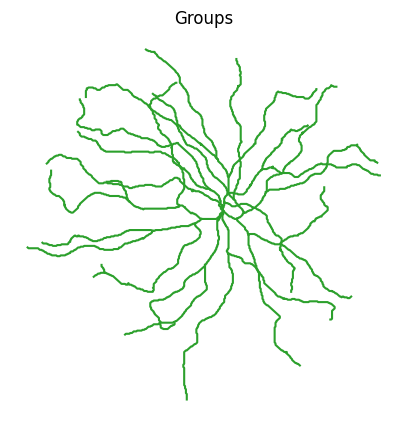

In [16]:
# cell = jx.read_swc(f"{base_dir}/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0,assign_groups=True)
print(list(cell.groups.keys()))

# cell.soma.radius = 1000.0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, color=colors[2])
cell.soma.vis(ax=ax, color=colors[1])
plt.axis("off")
plt.title("Groups")
plt.show()